In [231]:
import os
import sys
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
base_dir = os.path.join("/home/jovyan/work/Corona/COVID-19")
sys.path.append(base_dir)
import model as md

In [339]:
merger = md.Merger(data_dir="data", load_from_raw=False, load_from_agg=True)

In [340]:
# merger.convert_deaths_df()
df = merger.merge_deaths_df()

In [341]:
list(df["date"].unique())

[numpy.datetime64('2020-03-31T00:00:00.000000000')]

In [342]:
df = merger.load_deaths_df()
df = df[df["date"]>="2021-04-08"]
df[(df["Kor"]==47) & (df["Nem"]=="F")].compute().head(20)

,Sorszám,Nem,Kor,Alapbetegségek,date
48,22633,F,47,"epilepszia, májmûködés zavar",2021-04-08
127,22554,F,47,"magasvérnyomás-betegség, tiszta hypercholester...",2021-04-08
1314,21367,F,47,nem ismert alapbetegség,2021-04-08
1393,21288,F,47,magasvérnyomás-betegség,2021-04-08
2053,20628,F,47,cukorbetegség,2021-04-08
2160,20521,F,47,nem ismert alapbetegség,2021-04-08
2174,20507,F,47,"magasvérnyomás-betegség, cukorbetegség, elhízá...",2021-04-08
2810,19871,F,47,magas vérnyomás,2021-04-08
3393,19288,F,47,"magasvérnyomás-betegség, vesebetegség",2021-04-08
3507,19174,F,47,"szívritmuszavar, szívizom-betegség",2021-04-08


In [343]:
df_additional = merger.df["details"][["date","additional.infected"]].set_index("date")

In [344]:
df_tests = merger.show_kpi_hu()[["tests"]].reset_index()
df_tests["index"] = pd.to_datetime(df_tests["index"], format='%Y-%m-%d').dt.date
df_tests["additional.tests"] = df_tests.apply(
    lambda row: row["tests"]-df_tests[
        df_tests["index"]==row["index"] - pd.Timedelta(1, unit='D')
    ]["tests"].max(), 
    axis=1
)
df_tests = df_tests.set_index("index")

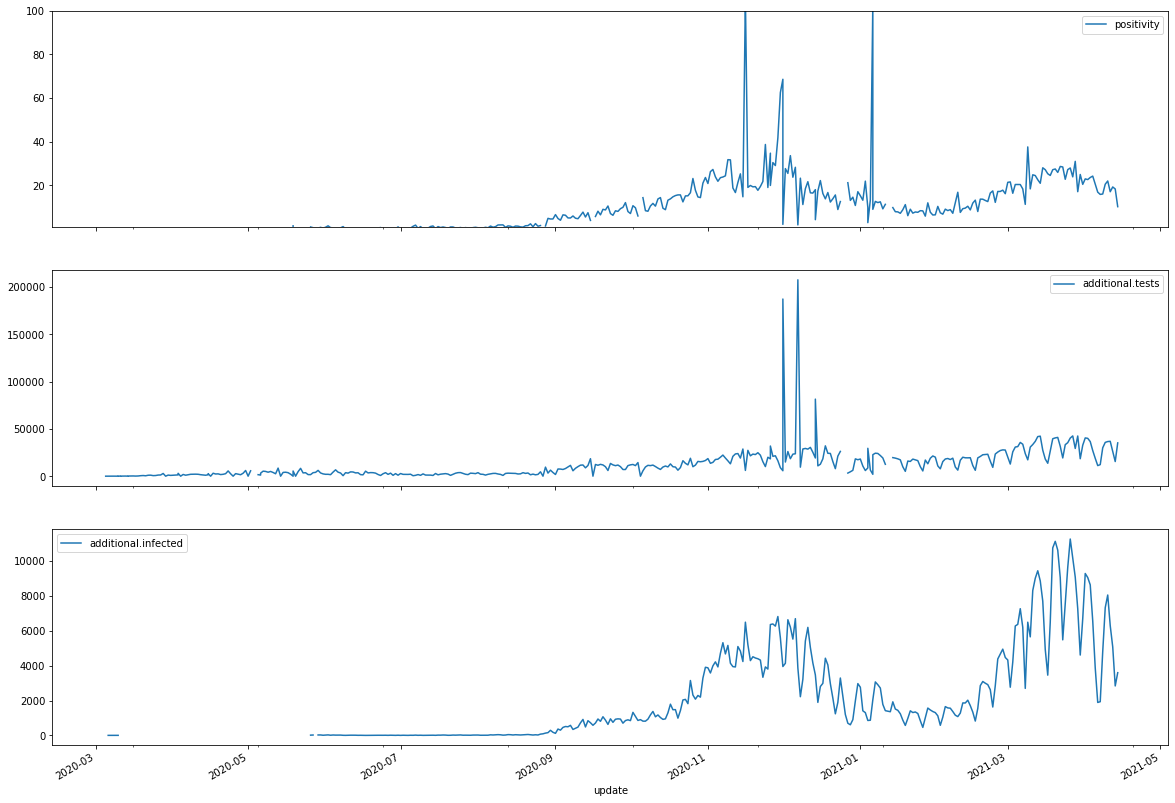

In [345]:
df_join = df_tests.join(df_additional).reset_index()
df_join["positivity"] = df_join["additional.infected"]/df_join["additional.tests"]*100
df_join["Country/Region"] = "HU"
df_join["update"] = df_join["index"]
(fig, ax) = plt.subplots(figsize=(20,15), nrows=3, sharex=True)
ax[0].set_ylim(1,100)
df_join.plot(x="update", y="positivity", ax=ax[0])
df_join.plot(x="update", y="additional.tests", ax=ax[1])
df_join.plot(x="update", y="additional.infected", ax=ax[2])
plt.show()

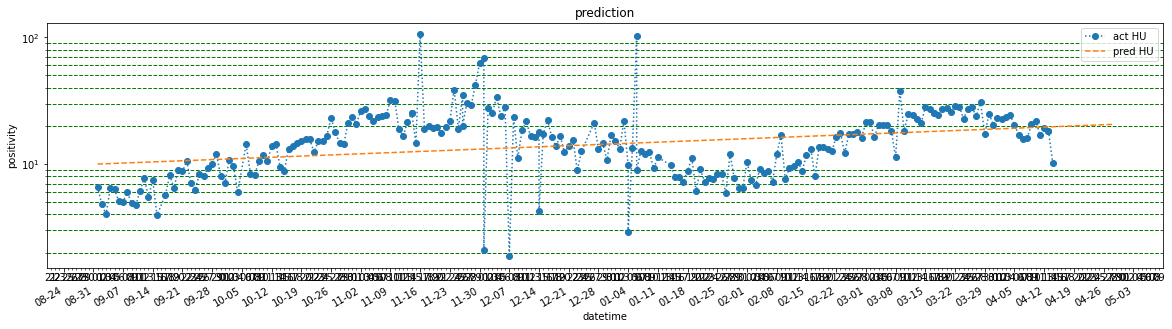

Coefficient of determination: {'HU': 0.10696851757160274}
Evolution factor per day: {'HU': 1.0}
Doubling in day(s): {'HU': 2.0}


,index,tests,additional.tests,additional.infected,positivity,Country/Region,update
444,2021-04-11,4934786.0,36864.0,6296.0,17.078993,HU,2021-04-11
445,2021-04-12,4961146.0,26360.0,5077.0,19.260243,HU,2021-04-12
446,2021-04-13,4976613.0,15467.0,2837.0,18.342277,HU,2021-04-13
447,2021-04-13,4976613.0,15467.0,2837.0,18.342277,HU,2021-04-13
448,2021-04-14,5011794.0,35181.0,3597.0,10.224269,HU,2021-04-14


In [346]:
tmpDf = md.DataProcessing.Analyse.start_analyse(
    df_join[
        (df_join["additional.tests"]>0) & (df_join["index"]>=pd.Timestamp("2020-09-01"))
    ].dropna(),
    ["HU"],
    "positivity", 
    "positivity"
)
df_join.tail()

# Check plausibility

In [347]:
# Details
selected_details_df = merger.df["details"][[
    "date", "additional.infected", "additional.deaths", 
    "cumulated.infected", "cumulated.recoveredFromHospital", 
    "onVentilator", "hospital", "active.infected"
]].copy()
selected_details_df.columns = [
    "date", "news.add.infected", "news.add.deaths", 
    "news.cum.infected", "news.cum.recovered", 
    "news.onVentilator", "news.hospital", "news.active"
]
selected_details_df["date"] = pd.to_datetime(selected_details_df["date"], format='%Y-%m-%d').dt.date
selected_details_df["news.add.recovered"] = selected_details_df.apply(
    lambda row: row["news.cum.recovered"] - selected_details_df[
        selected_details_df["date"]<row["date"]
    ]["news.cum.recovered"].max(), axis=1
)
selected_details_df = selected_details_df.set_index("date")

# KPI
selected_kpi_df = merger.show_kpi_hu()[["infected"]].copy().reset_index()
selected_kpi_df.columns = ["date", "kpi.cum.infected"]
selected_kpi_df["date"] = pd.to_datetime(selected_kpi_df["date"], format='%Y-%m-%d').dt.date
selected_kpi_df = selected_kpi_df.set_index("date")

selected_details_df.join(selected_kpi_df).tail()

,news.add.infected,news.add.deaths,news.cum.infected,news.cum.recovered,news.onVentilator,news.hospital,news.active,news.add.recovered,kpi.cum.infected
date,,,,,,,,,
2021-04-11,6296.0,206.0,720164,426394.0,1290.0,10484.0,270353.0,3028.0,720164.0
2021-04-12,5077.0,291.0,725241,429074.0,1249.0,10740.0,272241.0,2680.0,725241.0
2021-04-13,2837.0,272.0,728078,431124.0,1209.0,10818.0,272974.0,2050.0,728078.0
2021-04-13,2837.0,272.0,728078,431124.0,1209.0,10818.0,272974.0,2050.0,728078.0
2021-04-14,3597.0,285.0,731675,435344.0,1204.0,10364.0,272066.0,4220.0,731675.0


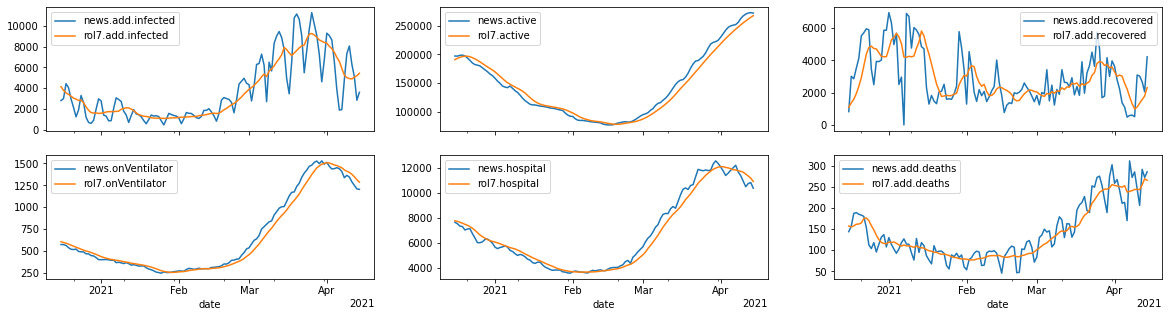

In [348]:
(fig, axs) = plt.subplots(figsize=(20,5), nrows=2, ncols=3, sharex=True)
plot_df = selected_details_df
configuration = {
    "add.infected":(0, 0), "onVentilator":(1,0),   # 1st col
    "active":(0,1),        "hospital":(1,1),       # 2nd col
    "add.recovered":(0,2), "add.deaths":(1,2)      # 3rd col
}
for category in configuration:
    plot_df["rol7.{}".format(category)] = plot_df.rolling(7).mean()[[f"news.{category}"]]
plot_df = plot_df.reset_index().tail(120)

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
for (category, position) in configuration.items():
    my_ax = axs[position[0]][position[1]]
    my_ax.xaxis.set_major_locator(locator)
    my_ax.xaxis.set_major_formatter(formatter)
    plot_df.plot(x="date", y="news.{}".format(category), ax=my_ax)
    plot_df.plot(x="date", y="rol7.{}".format(category), ax=my_ax)
plt.show()

In [349]:
#plot_df["add.infected"] = plot_df.apply(lambda row: plot_df[plot_df["date"]<], axis=1)
#plot_df.head()
plot_df.tail(10)

,date,news.add.infected,news.add.deaths,news.cum.infected,news.cum.recovered,news.onVentilator,news.hospital,news.active,news.add.recovered,rol7.add.infected,rol7.onVentilator,rol7.active,rol7.hospital,rol7.add.recovered,rol7.add.deaths
395,2021-04-05,3874.0,213.0,689853,418084.0,1451.0,11806.0,249841.0,1112.0,6961.285714,1475.428571,236121.571429,11924.000000,2589.000000,252.428571
396,2021-04-06,1890.0,170.0,691743,418568.0,1440.0,12007.0,251077.0,484.0,6572.857143,1462.714286,240226.285714,11846.000000,2229.142857,237.571429
397,2021-04-07,1933.0,311.0,693676,419152.0,1407.0,12202.0,252115.0,584.0,5891.857143,1450.571429,244134.000000,11825.428571,1745.285714,238.857143
398,2021-04-08,4814.0,272.0,698490,419765.0,1337.0,11663.0,256044.0,613.0,5252.714286,1425.571429,247831.571429,11768.428571,1314.285714,240.857143
399,2021-04-09,7325.0,285.0,705815,420275.0,1364.0,11363.0,262574.0,510.0,5005.571429,1410.857143,251607.285714,11713.571429,986.428571,243.428571
400,2021-04-10,8053.0,245.0,713868,423366.0,1344.0,10921.0,267291.0,3091.0,4922.142857,1397.571429,255176.285714,11647.571429,1109.285714,243.857143
401,2021-04-11,6296.0,206.0,720164,426394.0,1290.0,10484.0,270353.0,3028.0,4883.571429,1376.142857,258470.714286,11492.285714,1346.000000,243.142857
402,2021-04-12,5077.0,291.0,725241,429074.0,1249.0,10740.0,272241.0,2680.0,5055.428571,1347.285714,261670.714286,11340.000000,1570.000000,254.285714
403,2021-04-13,2837.0,272.0,728078,431124.0,1209.0,10818.0,272974.0,2050.0,5190.714286,1314.285714,264798.857143,11170.142857,1793.714286,268.857143
404,2021-04-14,3597.0,285.0,731675,435344.0,1204.0,10364.0,272066.0,4220.0,5428.428571,1285.285714,267649.000000,10907.571429,2313.142857,265.142857


In [350]:
baseDf = pd.read_csv("data/map_data/map_dataframe_per_megye.csv", delimiter=",")[['date','region','confirmed']]
normDf = pd.read_csv("data/base/base_dataframe_per_megye.csv", delimiter=",")
baseDf = baseDf.merge(normDf, on="region")
# Convert date column and add week/dayofweek
baseDf["date"] =  pd.to_datetime(baseDf["date"], format="%Y-%m-%d")
baseDf["conf_per_100k"] = baseDf["confirmed"]/baseDf["population"]*100000
max_date = baseDf["date"].max()
date_list = [
    max_date - dt.timedelta(days=21),
    max_date - dt.timedelta(days=14),
    max_date - dt.timedelta(days=7),
    max_date
]
last_kpi = baseDf[baseDf["date"].isin(date_list)].pivot(
    index="region",
    columns="date",
    values="conf_per_100k"
)
last_kpi.columns = ["d-21", "d-14", "d-7", "d"]
last_kpi["w_2"] = last_kpi["d-14"] - last_kpi["d-21"]
last_kpi["w_1"] = last_kpi["d-7"] - last_kpi["d-14"]
last_kpi["w_0"] = last_kpi["d"] - last_kpi["d-7"]
last_kpi["+_1.5"] = last_kpi["w_1"] - last_kpi["w_2"]
last_kpi["+_0.5"] = last_kpi["w_0"] - last_kpi["w_1"]
last_kpi = last_kpi.join(normDf.set_index("region")[["population"]])
last_kpi["warning"] = 250
last_kpi["alert"] = 500

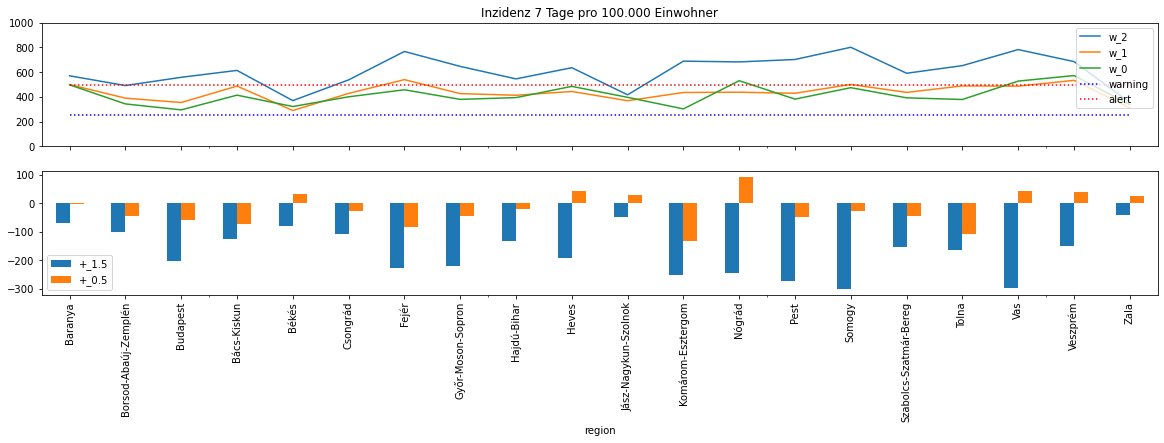

In [351]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,5), sharex=True)
ax[0].set_title("Inzidenz 7 Tage pro 100.000 Einwohner")
#> 500 – 1.000
#> 250 – 500
#> 100 – 250
#> 50 – 100
#> 25 – 50
#> 5 – 25
#> 0 – 5

last_kpi.plot.line(y=["w_2","w_1","w_0"], ax=ax[0])
last_kpi.plot.line(y=["warning","alert"], ax=ax[0], style=["b:","r:"])
last_kpi.plot.bar(y=["+_1.5","+_0.5"], ax=ax[1])
ax[0].set_ylim(0, 1000)
plt.show()

In [352]:
last_kpi["time_serie"] = last_kpi.apply(
    lambda row: [
        row["d-14"]-row["d-21"], 
        row["d-7"]-row["d-14"], 
        row["d"]-row["d-7"]
    ], axis=1
)

def print_limits(ax, x1, x2):
    ax.add_patch(Rectangle((x1, 0), x2-x1, 5, linewidth=1, edgecolor='none', facecolor='#fffccd'))
    ax.add_patch(Rectangle((x1, 5), x2-x1, 20, linewidth=1, edgecolor='none', facecolor='#fff380'))
    ax.add_patch(Rectangle((x1, 25), x2-x1, 25, linewidth=1, edgecolor='none', facecolor='#ffb534'))
    ax.add_patch(Rectangle((x1, 50), x2-x1, 50, linewidth=1, edgecolor='none', facecolor='#d43624'))
    ax.add_patch(Rectangle((x1, 100), x2-x1, 150, linewidth=1, edgecolor='none', facecolor='#951214'))
    ax.add_patch(Rectangle((x1, 250), x2-x1, 250, linewidth=1, edgecolor='none', facecolor='#671212'))
    ax.add_patch(Rectangle((x1, 500), x2-x1, 500, linewidth=1, edgecolor='none', facecolor='#dd0085'))

['Baranya', 'Borsod-Abaúj-Zemplén', 'Budapest', 'Bács-Kiskun', 'Békés', 'Csongrád', 'Fejér', 'Győr-Moson-Sopron', 'Hajdú-Bihar', 'Heves', 'Jász-Nagykun-Szolnok', 'Komárom-Esztergom', 'Nógrád', 'Pest', 'Somogy', 'Szabolcs-Szatmár-Bereg', 'Tolna', 'Vas', 'Veszprém', 'Zala']


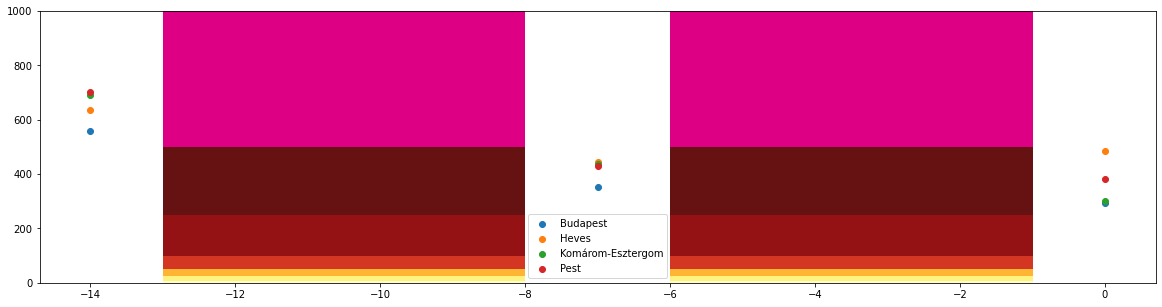

In [353]:
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(figsize=(20,5))
print_limits(ax, -13, -8)
print_limits(ax, -6, -1)
print(list(last_kpi.index))
for region in list(last_kpi.index):
    if region in ["Heves", "Budapest", "Pest", "Komárom-Esztergom"]:
        ax.scatter(x=[-14,-7,0], y=last_kpi.loc[region]["time_serie"], cmap=plt.get_cmap("tab20"), label=region)
ax.set_ylim(0,1000)
ax.legend()
plt.show()

In [354]:
vaccinated_df = merger.df["details"][
    ["date","cumulated.vaccinated","cumulated.vaccinated2"]
].dropna()
vaccinated_df["additional.vaccinated"] = (
    vaccinated_df[["cumulated.vaccinated"]] - vaccinated_df[["cumulated.vaccinated"]].shift(periods=1)
)
vaccinated_df["additional.vaccinated2"] = (
    vaccinated_df[["cumulated.vaccinated2"]] - vaccinated_df[["cumulated.vaccinated2"]].shift(periods=1)
)
vaccinated_df["add.vaccinated_rol7"] = vaccinated_df.rolling(7).sum()[["additional.vaccinated"]]
vaccinated_df["add.vaccinated2_rol7"] = vaccinated_df.rolling(7).sum()[["additional.vaccinated2"]]
vaccinated_df["cumulated.vaccinated2_soll"] = vaccinated_df[["cumulated.vaccinated"]].shift(periods=28)
vaccinated_df[vaccinated_df["date"]<="2021-03-31"].tail()

,date,cumulated.vaccinated,cumulated.vaccinated2,additional.vaccinated,additional.vaccinated2,add.vaccinated_rol7,add.vaccinated2_rol7,cumulated.vaccinated2_soll
386,2021-03-27,1870631.0,667303.0,67098.0,72641.0,350281.0,201660.0,563601.0
387,2021-03-28,1903498.0,685971.0,32867.0,18668.0,340256.0,211080.0,677682.0
388,2021-03-29,1920347.0,689392.0,16849.0,3421.0,330735.0,210003.0,685247.0
389,2021-03-30,2000998.0,721290.0,80651.0,31898.0,364562.0,239470.0,721677.0
390,2021-03-31,2011029.0,753187.0,10031.0,31897.0,314919.0,258667.0,758037.0


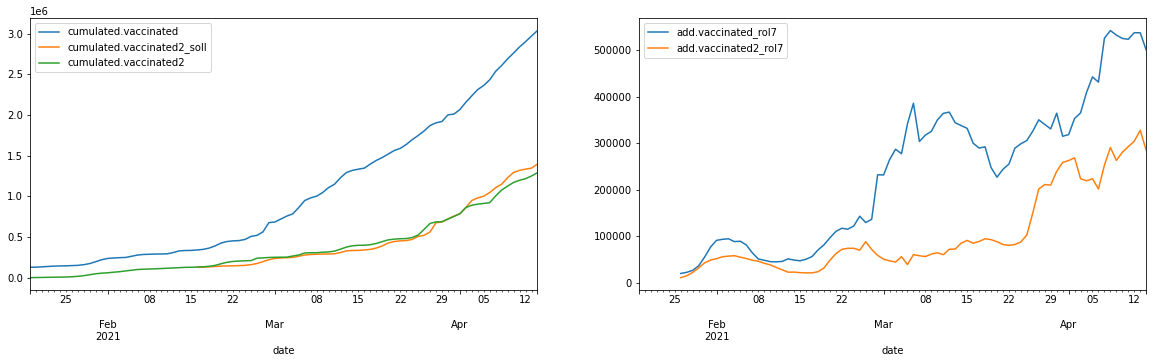

In [355]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
vaccinated_df.plot(x="date", y=[
    "cumulated.vaccinated","cumulated.vaccinated2_soll", "cumulated.vaccinated2"
], ax=ax[0])
vaccinated_df.plot(x="date", y=["add.vaccinated_rol7","add.vaccinated2_rol7"], ax=ax[1])
plt.show()